# Predicting Bike Rentals

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

<a href=http://www.liaad.up.pt/area/fanaee>Hadi Fanaee-T</a> at the <a href=http://www.up.pt/>University of Porto</a> compiled this data into a CSV file, which we'll work with in this project. The file contains `17380` rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the <a href=http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset>University of California, Irvine's website</a>.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
bike_rentals = pd.read_csv("additional_files/Bike_rentals_hour.csv")

Here is a preview of the first five rows of the data set:

In [5]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


The relevant columns have the following description:

* `instant` - A unique sequential ID number for each row
* `dteday` -  The date of the rentals
* `season` - The season in which the rentals occurred
* `yr` - The year the rentals occurred
* `mnth` - The month the rentals occurred
* `hr` - The hour the rentals occurred
* `holiday` - Whether or not the day was a holiday
* `weekday` - The day of the week (as a number, `0` to `6`)
* `workingday` - Whether or not the day was a working day
* `weathersit` - The weather (as a categorical variable)
* `temp` - The temperature, on a `0-1` scale
* `atemp` -  The adjusted temperature
* `hum` - The humidity, on a `0-1` scale
* `windspeed` - The wind speed, on a `0-1` scale
* `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* `registered` - The number of registered riders (people who had already signed up)
* `cnt` - The total number of bike rentals (`casual` + `registered`)

In this project, we'll try to predict the total number of bikes people rented in a given hour. We'll predict the `cnt` column using all of the other columns, except for `casual` and `registered`. To accomplish this, we'll create a few different machine learning models and evaluate their performance.

To get an first overview, we visualize the `cnt` column as a histogram:

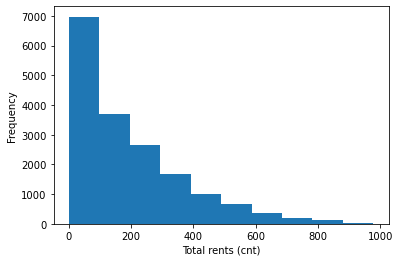

In [10]:
bike_rentals["cnt"].plot.hist()
plt.xlabel("Total rents (cnt)")
plt.show()

Futher, we observe the correlation of the features with the `cnt` column:

In [20]:
cnt_corrs = bike_rentals.corr()["cnt"]
cnt_corrs.sort_values()

time_label   -0.378318
hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

***
### Calculating Features

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information or distilling existing information.

For example, the `hr` column in `bike_rentals` contains the hours during which bikes are rented, from 1 to 24. A machine treats each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column (`time_label`) with labels for `morning` (1), `afternoon` (2), `evening` (3), and `night` (4). This bundles similar times together, enabling the model to make better decisions.

In [14]:
def assign_label(hour):
    if (hour >= 6) & (hour < 12):
        return 1
    elif (hour >= 12) & (hour < 18):
        return 2
    elif (hour >= 18) & (hour <= 24):
        return 3
    elif (hour >= 0) & (hour < 6):
        return 4

bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

In [17]:
bike_rentals.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,4
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1,4
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2,1
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3,1
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8,1
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14,1


***
### Splitting the Data Into Train and Test Sets

Before we can begin applying machine learning algorithms, we'll need to split the data into training and testing sets. This enabels us to train the algorithm using the training set, and evaluate its accuracy on the testing set.

In [18]:
train = bike_rentals.sample(frac=.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

***
### Error Metric

The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

In [19]:
from sklearn.metrics import mean_squared_error

***
### Applying Linear Regression

Now we are ready to apply linear regression to the data. Linear regression schould work fairly well on this data, given that many of the columns are highly correlated with `cnt`.

In [45]:
from sklearn.linear_model import LinearRegression

#features = ["time_label","hum","weathersit","mnth","season","yr","instant","hr","temp"]
features = predictors = list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")
target = "cnt"

lr = LinearRegression()
lr.fit(train[features],train[target])

predictions = lr.predict(test[features])
error = mean_squared_error(test[target],predictions)
print(error)

18073.681299041575


The calculated error of `~18073` is quite high which could be due to some extreme outliers in the `cnt` column that are penalized more with MSE and could lead to a higher total error.

***
### Applying Decision Trees

Next, we will apply the decision tree algorithm. Afterwards, we'll be able to compare the decision tree algorithm error with the error from linear regression, which will enable us to pick the right algorithm for this dataset.

#### 1. Decision Tree with Default Parameters

In [46]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(train[features],train[target])

predictions = dt.predict(test[features])
error = mean_squared_error(test[target],predictions)
print(error)

3517.0184119677792


#### 2. Decision Tree with Limitted Minimum Samples Per Leaf

This error is already lower compared to the error of the linear regression model. Nevertheless, we try to further improve the decision tree performance by limitting the minimum samples per leaf (`min_samples_leaf`).

In [47]:
dt = DecisionTreeRegressor(min_samples_leaf=5)
dt.fit(train[features],train[target])

predictions = dt.predict(test[features])
error = mean_squared_error(test[target],predictions)
print(error)

2606.9405528214784


In [48]:
dt = DecisionTreeRegressor(min_samples_leaf=10)
dt.fit(train[features],train[target])

predictions = dt.predict(test[features])
error = mean_squared_error(test[target],predictions)
print(error)

2637.523432327309


The decision tree model with limitted minimum samples per leaf (n = 5) works significantly better (MSE = ~2606) in predicting the `cnt` column compared to the linear regression model (MSE = ~18073).

Next, as a try for further improvement use a random forest regressor which tends to be much more accurate than simple decision tree models.

### Applying Random Forests

Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests are prone to overfitting, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [49]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5)
rf.fit(train[features],train[target])

predictions = rf.predict(test[features])
error = mean_squared_error(test[target],predictions)
print(error)

1937.2707767939796


By removing some of the sources of overfitting, the random forest accuracy (MSE = ~1937) is improved over the decision tree accuracy (MSE = ~2606).